## Convolutional Neural Nets  
`reference`  
`https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html`  
## Torchvision  
### Load and normalize CIFAR10

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import numpy as np

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5),
                         (.5, .5, .5))
])

trainset = torchvision.datasets.CIFAR10(
    root='./data/cifar',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data/cifar', 
    train=False,
    download=True,
    transform=transform
)

batch_size = 128

m = len(trainset)

indices = list(range(m))

np.random.shuffle(indices)

validm = int(m * .2)
validm

trainindex, validindex = indices[validm:], indices[:validm]

trainsampler = SubsetRandomSampler(trainindex)

validsampler = SubsetRandomSampler(validindex)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=trainsampler)

validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=validsampler)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat','deer',
           'dog','frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


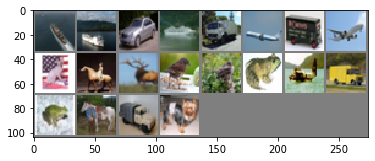

 ship  ship   car  ship truck plane truck plane   cat horse  deer  bird  bird  frog plane truck  frog horse truck   dog


In [5]:
def imshow(image):
    image = image / 2 + .5
    np_image = image.numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    plt.show()

# batch, labels
# images, labels = iter(trainloader).next()
# imshow(torchvision.utils.make_grid(images))

# print(' '.join('%5s' % classes[labels[i]] for i in range(batch_size)))

### Define a Convolutional Neural Network

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flattening
        x = x.view(-1, 64 * 4 * 4)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)


### Define a Loss function and optimizer

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=.1, momentum=.9)

### Train the network

In [10]:
epochs = 3

validloss_min = np.Inf

for epoch in range(epochs):
    
    trainloss = 0.0
    validloss = 0.0
    
    model.train()
    
    for data, target in trainloader:
        
        optimizer.zero_grad()
        
        #forward
        output = model(data)
        
        #backward
        loss = criterion(output, target)
        loss.backward()
        
        #optimize
        optimizer.step()
        
        trainloss += loss.item() * data.size(0)
    
    model.eval()
    
    for data, target in validloader:
        output = model(data)
        
        loss = criterion(output, target)
        
        validloss += loss.item() * data.size(0)
    
    trainloss = trainloss / len(trainloader.dataset)
    validloss = validloss / len(validloader.dataset)
    
    print('%d training loss: %.3f \tvalidation loss: %.3f' % (epoch+1, trainloss, validloss))
    
    if validloss <= validloss_min:
        torch.save(model.state_dict(), './model/cifar/model_cifar.pt')
        validloss_min = validloss

1 training loss: 1.695 	validation loss: 0.388
2 training loss: 1.512 	validation loss: 0.338
3 training loss: 1.353 	validation loss: 0.315


### Load the model

In [ ]:
model.load_state_dict(torch.load('./model/cifar/model_cifar.pt'))

### Test the network on the test data

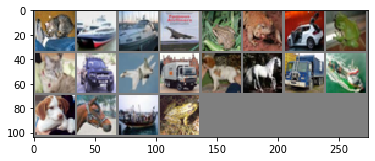

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog


In [14]:
images, labels = iter(testloader).next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[i]] for i in range(batch_size)))

In [13]:
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[i]] for i in range(batch_size)))

Predicted:    cat  ship  ship  ship  frog  frog   car  deer   dog   car plane truck  frog horse   car  ship   dog   cat  ship  frog


In [15]:
correct = 0
total = 0

with torch.no_grad():
    for data, target in testloader:
        output = model(data)
        _, predict = torch.max(output, 1)
        
        total += target.size(0)
        correct += (predict == target).sum().item()

print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10,000 test images: 43 %


In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data, target in testloader:        
        
        output = model(data)
        _, predict = torch.max(output, 1)
        c = (predict == target).squeeze()
        
        for i in range(4):
            label = target[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 75 %
Accuracy of  bird :  7 %
Accuracy of   cat : 10 %
Accuracy of  deer : 34 %
Accuracy of   dog : 37 %
Accuracy of  frog : 57 %
Accuracy of horse : 57 %
Accuracy of  ship : 47 %
Accuracy of truck : 50 %
